<a href="https://colab.research.google.com/github/MarkusThill/MarkusThill.github.io-jupyter/blob/main/intro_neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-Forward Neural Network from Scratch (Toy Example)

This notebook accompanies the blog post and provides a **minimal, fully transparent implementation** of a feed-forward neural network trained with **backpropagation** and **gradient descent**, written entirely from scratch using NumPy.

The goal here is *not* performance or flexibility, but **understanding**. Every step of the training process—forward pass, loss computation, backpropagation, parameter updates, and gradient checking—is implemented explicitly, without relying on automatic differentiation or high-level deep-learning frameworks.

---

## Relation to the Blog Post

This notebook is a **hands-on companion** to the blog post

> **“Backpropagation from Scratch: Feed-Forward Neural Networks in Matrix Notation”**

The blog post focuses on:
- precise **notation and mathematical derivations**
- a step-by-step development of the **forward pass and backpropagation equations**
- practical considerations such as gradient checking, initialization, and batching

This notebook, in contrast, shows how those equations translate **directly into runnable code**:
- every matrix expression appears almost verbatim in NumPy
- no automatic differentiation or deep-learning frameworks are used
- gradient checking validates the theory numerically

Reading the blog post and working through this notebook side by side is recommended:
the math explains *why* the algorithm works, while the code shows *how* it is implemented in practice.

---


## What this notebook demonstrates

- How to generate simple **2D toy datasets** (moons, circles, blobs) for binary classification
- A **fully vectorized feed-forward neural network** with
  - explicit weight matrices and bias vectors  
  - sigmoid activations  
  - binary cross-entropy loss
- A clean **backpropagation implementation** that mirrors the mathematical derivation
- **Gradient checking via finite differences** to validate the correctness of the gradients
- Visualization of the learned **decision boundary** in input space
- A lightweight **accuracy check** after training

---

## Design choices (on purpose)

To keep the example as clear as possible:

- The entire dataset is used for training (no train/validation/test split)
- A fixed learning rate and plain gradient descent are used
- No regularization, dropout, or adaptive optimizers are included
- The network is intentionally small and easy to reason about

These simplifications make the code easy to map back to the math.  
Extensions and best practices (validation splits, optimizers, regularization, deeper networks) are discussed in the accompanying blog post.

---

## How to read this notebook

A good way to approach this notebook is:

1. Skim the **dataset generation and visualization**
2. Read the **layer and network classes** together with the backprop equations
3. Run the **training loop** and observe the loss decreasing
4. Inspect the **decision boundary plot**
5. Use **gradient checking** to convince yourself that the implementation is correct

If you can follow everything here, you have a solid mental model of how modern neural networks are trained under the hood.

---


# Setup

## Necessary Imports

In [1]:
from __future__ import annotations
"""
Basic imports used throughout the notebook.

This notebook implements and trains a small feed-forward neural network
*from scratch* using NumPy, and visualizes its behavior on simple 2D
toy datasets.
"""

# Numerical computations (vectors, matrices, linear algebra)
import numpy as np

# Plotting utilities for visualizing datasets and decision boundaries
import matplotlib.pyplot as plt

# Toy datasets for binary classification experiments
from sklearn.datasets import make_moons, make_circles, make_blobs

# Type hints for clearer function signatures
from collections.abc import Callable
from typing import Any


## Helpers for Creating A Toy Dataset

In [2]:
"""
Generate and visualize simple 2D toy datasets for binary classification,
and provide a helper to plot the decision boundary of an arbitrary predictor.

These utilities are used throughout the notebook to:
- create intuition for classification problems,
- visualize what the neural network learns,
- keep examples simple and fully reproducible.

Requires: numpy, matplotlib, scikit-learn
"""

def generate_toy_dataset(
    n_samples: int = 1000,
    noise: float = 0.2,
    dataset_type: str = "moons",
    random_state: int = 42,
):
    """
    Generate a 2D toy binary classification dataset.

    The datasets are intentionally low-dimensional so that decision
    boundaries can be visualized directly.

    Args:
        n_samples: Total number of samples.
        noise: Standard deviation of Gaussian noise added to the data.
        dataset_type: One of {"moons", "circles", "blobs"}.
        random_state: Seed for reproducibility.

    Returns:
        X: Input features of shape (n_samples, 2)
        y: Binary labels of shape (n_samples,)
    """

    if dataset_type == "moons":
        # Non-linearly separable two-moons dataset
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)

    elif dataset_type == "circles":
        # Concentric circles (classic example requiring nonlinearity)
        X, y = make_circles(
            n_samples=n_samples, noise=noise, factor=0.5, random_state=random_state
        )

    elif dataset_type == "blobs":
        # Linearly separable Gaussian clusters
        X, y = make_blobs(
            n_samples=n_samples,
            centers=2,
            n_features=2,
            cluster_std=noise,
            random_state=random_state,
        )

    else:
        raise ValueError("dataset_type must be 'moons', 'circles', or 'blobs'.")

    return X, y


def visualize_dataset(X, y, title: str = "Toy Dataset") -> None:
    """
    Scatter plot of a 2D dataset with color-coded class labels.

    This is typically used to inspect the raw input data
    before training a classifier.
    """
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=40)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()


def plot_decision_boundary(
    predict_fn,
    X: np.ndarray,
    y: np.ndarray,
    title: str = "Decision boundary",
    grid_steps: int = 300,
) -> None:
    """
    Plot the decision boundary of an arbitrary predictor together with the data.

    The predictor is treated as a black box. It only needs to accept an array
    of shape (N, 2) and return either class labels, scores, or probabilities.

    This makes the function compatible with:
    - our own neural network implementation,
    - scikit-learn classifiers,
    - simple hand-written predictors.
    """

    # Create a dense grid covering the data range
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_steps),
        np.linspace(y_min, y_max, grid_steps),
    )

    # Flatten grid into (N, 2) array for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Evaluate the model on the grid
    Z = np.asarray(predict_fn(grid))

    # Normalize common prediction shapes to a flat score/probability vector
    if Z.ndim == 2 and Z.shape[1] == 1:
        Z = Z[:, 0]
    elif Z.ndim == 2 and Z.shape[1] == 2:
        # Heuristic: assume column 1 corresponds to class 1
        Z = Z[:, 1]

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))

    # If predictions look like probabilities in [0, 1],
    # visualize a probability field with decision boundary at 0.5
    if np.nanmin(Z) >= 0.0 and np.nanmax(Z) <= 1.0:
        cf = plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)
        plt.colorbar(cf, label="P(class=1)")
        plt.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=2)
    else:
        # Otherwise treat Z as a generic score
        cf = plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)
        plt.colorbar(cf, label="score")
        plt.contour(xx, yy, Z, levels=[0.0], colors="k", linewidths=2)

    # Overlay the training data
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=40)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# Example predictor (for demonstration only)
# ---------------------------------------------------------------------
# This dummy function illustrates the expected interface of `predict_fn`.
# It can be replaced by a neural network forward pass, e.g. net.forward.
def dummy_predict_fn(x: np.ndarray) -> np.ndarray:
    # Simple linear score
    score = x[:, 0] - x[:, 1]

    # Map score to [0, 1] via a sigmoid
    probs = 1 / (1 + np.exp(-score))
    return probs

# Specify the Components of  Simple Feed-Forward Neural Network

## Binary Cross Entropy Loss, Cost Function and Relative Error Function

In [3]:
def bce_loss(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    eps: float = 1e-12,
) -> np.ndarray:
    """
    Compute the binary cross-entropy loss element-wise.

    This function returns the loss per sample (or per output unit),
    without aggregating over the batch. Aggregation is handled
    separately by `bce_cost`.

    Args:
        y_true: Ground-truth labels, typically of shape (N,) or (1, N),
            with values in {0, 1}.
        y_pred: Predicted probabilities, same shape as `y_true`,
            with values in (0, 1).
        eps: Small constant for numerical stability to avoid
            log(0) and log(1).

    Returns:
        Element-wise binary cross-entropy loss with the same shape
        as `y_true`.
    """
    # Prevent numerical issues for log(0) and log(1)
    y_pred = np.clip(y_pred, eps, 1.0 - eps)

    return -(y_true * np.log(y_pred) + (1.0 - y_true) * np.log1p(-y_pred))


def bce_cost(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    agg: Callable[[np.ndarray], float] = np.mean,
) -> float:
    """
    Compute the scalar binary cross-entropy cost over a batch.

    This corresponds to the batch-averaged cost function

        J(Θ) = (1/N) ∑ₙ ℒ(yₙ*, ŷₙ),

    where ℒ denotes the binary cross-entropy loss.

    Args:
        y_true: Ground-truth labels of shape (N,) or (1, N).
        y_pred: Predicted probabilities of the same shape as `y_true`.
        agg: Aggregation function applied to the element-wise loss.
            Defaults to the mean over the batch.

    Returns:
        Scalar cost value representing the average binary
        cross-entropy over the batch.
    """
    return agg(bce_loss(y_true, y_pred))


def relative_error(
    a: np.ndarray,
    b: np.ndarray,
    stability_eps: float = 1e-10,
) -> np.ndarray:
    """
    Compute the element-wise relative error between two arrays.

    This is primarily used for gradient checking, where analytical
    gradients obtained via backpropagation are compared against
    numerical (finite-difference) gradients.

    Args:
        a: First array (e.g. numerical gradient).
        b: Second array (e.g. backpropagation gradient).
        stability_eps: Small constant added to the denominator
            to avoid division by zero when both values are close
            to zero.

    Returns:
        Element-wise relative error array with the same shape
        as `a` and `b`.
    """
    return np.abs(a - b) / (np.abs(a) + np.abs(b) + stability_eps)

## Abstract `Layer` Class

In [4]:
class Layer:
    """
    Abstract base class for all network layers.

    A layer represents one transformation A^{(ℓ-1)} → A^{(ℓ)} in the network.
    Concrete subclasses (e.g. HiddenLayer, InputLayer) implement the actual
    forward computation and parameter updates.

    The base class mainly defines the shared interface and bookkeeping
    required by the NeuralNetwork container.
    """

    # Human-readable identifier used for debugging and error messages
    name: str

    # Feature dimensions (resolved during network construction)
    in_features: int | None = None
    out_features: int | None = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Compute the forward pass of the layer.

        Args:
            X: Input activation matrix A^{(ℓ-1)} of shape
               (in_features, batch_size).

        Returns:
            Output activation matrix A^{(ℓ)} of shape
            (out_features, batch_size).
        """
        ...

    def update(self) -> None:
        """
        Update the layer's trainable parameters.

        For layers without parameters (e.g. input layers), this is a no-op.
        """
        ...

    def __init__(self, name: str, out_features: int) -> None:
        """
        Initialize a layer with a given output dimensionality.

        The input dimensionality is not yet known at this stage and will be
        provided later by the NeuralNetwork during the build phase.

        Args:
            name: Descriptive name of the layer (used for debugging).
            out_features: Number of output units d_ℓ of the layer.
        """
        self.name = name
        self.out_features = out_features
        self.in_features: int | None = None

        # Cached values from the forward pass (needed for backpropagation)
        self.A: np.ndarray | None = None  # Activations A^{(ℓ)}
        self.Z: np.ndarray | None = None  # Pre-activations Z^{(ℓ)}

        # Derivative of the activation function σ′(·)
        # Defaults to identity (useful for input layers)
        self.σ_prime: Callable[[np.ndarray], np.ndarray] = lambda x: np.ones_like(x)

    def build(self, in_features: int, lr: float = 1.0) -> None:
        """
        Finalize layer dimensions and hyperparameters.

        This method is called exactly once by the NeuralNetwork after the
        previous layer is known. Subclasses may override this method to
        allocate parameters (weights, biases).

        Args:
            in_features: Number of input units d_{ℓ-1}.
            lr: Learning rate η used for parameter updates.
        """
        self.in_features = in_features
        self.η = lr

    @staticmethod
    def _sigmoid(x: np.ndarray) -> np.ndarray:
        """
        Sigmoid activation function applied element-wise.

        Args:
            x: Input array.

        Returns:
            Output array with values in (0, 1).
        """
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def _sigmoid_prime(x: np.ndarray) -> np.ndarray:
        """
        Derivative of the sigmoid activation function.

        Args:
            x: Pre-activation values.

        Returns:
            Element-wise derivative σ′(x).
        """
        σ = Layer._sigmoid(x)
        return σ * (1.0 - σ)


## `Hidden/Dense` Layer Class

In [5]:
class Dense(Layer):
    """
    Fully-connected (affine + nonlinearity) layer.

    In our notation, this layer implements the batched forward map

        Z^{(ℓ)} = W^{(ℓ)} A^{(ℓ-1)} + b^{(ℓ)} 1^T,
        A^{(ℓ)} = σ(Z^{(ℓ)}),

    where A^{(ℓ-1)} has shape (d_{ℓ-1}, N) and A^{(ℓ)} has shape (d_ℓ, N).

    This class stores (A, Z) from the forward pass as a cache for backpropagation,
    and maintains gradients (dW, db) for gradient descent updates.
    """

    def __init__(self, name: str, units: int) -> None:
        """
        Create a Dense layer with `units` output neurons.

        Args:
            name: Descriptive name of the layer (used for debugging).
            units: Number of output units d_ℓ.
        """
        super().__init__(name, units)

        # Activation σ(·) and its derivative σ′(·) for this layer.
        # (Here: sigmoid; for ReLU etc. you would swap these out.)
        self.σ = Layer._sigmoid
        self.σ_prime = Layer._sigmoid_prime

        # Trainable parameters and their gradients.
        self.W: np.ndarray | None = None  # W^{(ℓ)} ∈ R^{d_ℓ × d_{ℓ-1}}
        self.b: np.ndarray | None = None  # b^{(ℓ)} ∈ R^{d_ℓ × 1}
        self.dW: np.ndarray | None = None  # ∂J/∂W^{(ℓ)}
        self.db: np.ndarray | None = None  # ∂J/∂b^{(ℓ)}

    def build(self, in_features: int, lr: float) -> None:
        """
        Finalize dimensions and initialize parameters.

        We use Glorot/Xavier uniform initialization for W^{(ℓ)} to break symmetry
        and to keep the scale of activations/gradients reasonable across layers.

        Args:
            in_features: Number of input features d_{ℓ-1}.
            lr: Learning rate η used for parameter updates.
        """
        super().build(in_features, lr)
        assert self.out_features is not None  # defined by __init__

        # Glorot/Xavier uniform: U(-sqrt(6/(fan_in+fan_out)), +sqrt(6/(fan_in+fan_out)))
        limit = np.sqrt(6.0 / (in_features + self.out_features))
        self.W = np.random.uniform(-limit, limit, (self.out_features, in_features))

        # Biases are commonly initialized to zero (no symmetry issue once W is random).
        self.b = np.zeros((self.out_features, 1))

        # Allocate gradient buffers (filled during backprop).
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward pass for a batch of inputs.

        Args:
            X: Input activations A^{(ℓ-1)} of shape (d_{ℓ-1}, N).

        Returns:
            Activations A^{(ℓ)} of shape (d_ℓ, N).
        """
        assert self.W is not None and self.b is not None

        # --------------------------------------------------------------------
        # Note: You *could* write the affine map with augmented matrices:
        #   [b  W] @ [1^T; X]
        # but we keep it explicit here and rely on broadcasting for the bias.
        # --------------------------------------------------------------------

        # Z^{(ℓ)} = W^{(ℓ)} A^{(ℓ-1)} + b^{(ℓ)} 1^T
        self.Z = self.W @ X + self.b  # b broadcasts across the batch dimension
        # A^{(ℓ)} = σ(Z^{(ℓ)})
        self.A = self.σ(self.Z)
        return self.A

    def backprop(self, prevLayer: Layer, Δ: np.ndarray) -> np.ndarray:
        """
        Backpropagate an incoming error signal through this layer.

        Here, Δ is the error matrix for *this* layer, i.e.
            Δ = Δ^{(ℓ)} = ∂J/∂Z^{(ℓ)} ∈ R^{d_ℓ × N}.

        This method computes the parameter gradients
            ∂J/∂W^{(ℓ)} and ∂J/∂b^{(ℓ)},
        and returns the previous layer's error
            Δ^{(ℓ-1)} = ∂J/∂Z^{(ℓ-1)}.

        Args:
            prevLayer: Layer (ℓ-1). Must provide cached activations A^{(ℓ-1)}
                       and Z^{(ℓ-1)} from the forward pass.
            Δ: Error matrix for this layer, shape (d_ℓ, N).

        Returns:
            Δ_prev: Error matrix for the previous layer, shape (d_{ℓ-1}, N).
        """
        assert prevLayer.A is not None
        assert prevLayer.Z is not None
        assert self.A is not None
        assert self.W is not None
        assert Δ.shape == self.A.shape
        assert self.W.shape[1] == prevLayer.A.shape[0]

        # Batch size N (your notation: 𝒩 or N)
        N = Δ.shape[1]

        # Gradients for this layer's parameters (batch-averaged):
        #
        # ∂J/∂W^{(ℓ)} = (1/N) Δ^{(ℓ)} (A^{(ℓ-1)})^T
        # ∂J/∂b^{(ℓ)} = (1/N) Δ^{(ℓ)} 1
        self.dW = (1.0 / N) * (Δ @ prevLayer.A.T)
        self.db = np.mean(Δ, axis=1, keepdims=True)

        # Propagate error to previous layer:
        #
        # Δ^{(ℓ-1)} = (W^{(ℓ)})^T Δ^{(ℓ)} ⊗ σ′(Z^{(ℓ-1)})
        #
        # Important: the σ′ factor belongs to the *previous* layer because Δ^{(ℓ-1)}
        # is defined w.r.t. Z^{(ℓ-1)}.
        Δ_prev = (self.W.T @ Δ) * prevLayer.σ_prime(prevLayer.Z)
        return Δ_prev

    def update(self) -> None:
        """
        Apply a gradient descent update step for this layer.

        Uses the learning rate η stored during `build()`:
            W ← W - η dW
            b ← b - η db
        """
        assert self.W is not None and self.b is not None
        assert self.dW is not None and self.db is not None

        self.W -= self.η * self.dW
        self.b -= self.η * self.db


## `Input` Layer Class

In [6]:
class Input(Layer):
    """
    Input layer (identity mapping).

    This layer has no trainable parameters. It mainly serves as a convenient
    place to define the feature dimension and to store the input batch as the
    cached activations for later layers.

    In our notation:

        A^{(0)} := X,
        Z^{(0)} := X,

    i.e., the input is treated as the "activation" of layer ℓ = 0.
    """

    def __init__(self, name: str, n_features: int) -> None:
        """
        Create an input layer that fixes the network input dimension.

        Args:
            name: Descriptive name of the layer (used for debugging).
            n_features: Input dimension d_0 (number of features).
        """
        super().__init__(name, n_features)

        # For an input layer, σ′ is effectively 1 everywhere (identity map).
        self.σ_prime = lambda x: np.ones_like(x)

        # For clarity, the input layer's in/out dimensions are the same.
        self.in_features = n_features
        self.out_features = n_features

    def build(self, in_features: int | None = None) -> None:
        """
        Finalize shapes for the input layer.

        The input layer defines the feature size d_0. It does not allocate any
        parameters. The `in_features` argument is ignored because the dimension
        is already given by `n_features` in `__init__`.

        Args:
            in_features: Ignored for the input layer.
        """
        # d_0 is already known; keep the convention in_features == out_features.
        self.in_features = self.out_features

    def forward(
        self,
        X: np.ndarray,
        grad_check_cost_fnc: Callable[[np.ndarray], float] | None = None,
    ) -> np.ndarray:
        """
        Forward pass (identity).

        Stores the input batch as both pre-activations and activations, so that
        downstream layers can consistently access `prevLayer.A` and `prevLayer.Z`.

        Args:
            X: Input batch matrix of shape (d_0, N).
            grad_check_cost_fnc: Optional hook used elsewhere for gradient checking.
                Not used in this layer (kept for a uniform call signature).

        Returns:
            The unchanged input X (same array values), shape (d_0, N).
        """
        # Cache input for consistency with later layers.
        self.Z = X
        self.A = X
        return self.A

    def update(self) -> None:
        """
        No-op update.

        The input layer has no trainable parameters, hence nothing to update.
        """
        pass

## `NeuralNetwork` Class

In [7]:
class NeuralNetwork:
    """
    Minimal feed-forward neural network (from scratch).

    The network is a sequence of `Layer` objects. Each parameterized layer stores
    its forward-pass caches (Z/A) and gradients (dW/db), so we can run backprop
    and then apply a simple gradient-descent update.

    In our notation (batch / matrix form):

        A^{(0)} := X
        Z^{(ℓ)} := W^{(ℓ)} A^{(ℓ-1)} + b^{(ℓ)} 1^T
        A^{(ℓ)} := σ(Z^{(ℓ)})
        Ŷ       := A^{(L)}

    and the parameters are updated via gradient descent:

        W^{(ℓ)} ← W^{(ℓ)} − η ∂J/∂W^{(ℓ)}
        b^{(ℓ)} ← b^{(ℓ)} − η ∂J/∂b^{(ℓ)}
    """

    def __init__(
        self,
        layers: list[Layer],
        loss_fn: Callable[[np.ndarray, np.ndarray], float],
        lr: float = 1.0,
    ) -> None:
        """
        Initialize the network and build all layers.

        Args:
            layers: Ordered list of layers. The first one is typically an `Input`
                layer that defines d_0 (feature dimension).
            loss_fn: Loss/cost callable of the form `(y_true, y_pred) -> scalar`.
                (In this notebook we mostly use BCE-related helpers.)
            lr: Learning rate η used by parameterized layers during `update()`.
                Note: Often it is cleaner to pass η to `fit()` instead of storing it
                globally, but we keep it simple here.
        """
        self.loss_fn = loss_fn  # expects (y_true, y_pred) -> scalar

        if not layers:
            raise ValueError("Network must have at least one layer.")

        self.lr = lr
        self.layers = layers
        self._build()

    def _build(self) -> None:
        """
        Finalize shapes and initialize parameters for all layers.

        The first layer (usually `Input`) defines the input dimension d_0.
        Each subsequent layer is built based on the previous layer's output size.
        """
        # First layer defines input size (d_0)
        self.layers[0].build(self.layers[0].out_features)

        # All following layers learn their input size from the previous layer.
        for prev, curr in zip(self.layers[:-1], self.layers[1:]):
            curr.build(prev.out_features, self.lr)

    def add(self, layer: Layer) -> None:
        """
        Append a layer to the network (sanity-checking shapes).

        Args:
            layer: The layer to append.

        Raises:
            ValueError: If the new layer's input dimension does not match the
                previous layer's output dimension.
        """
        if self.layers:
            prev = self.layers[-1]
            if prev.out_features is None or layer.in_features is None:
                raise ValueError("Both prev.out_features and layer.in_features must be set.")
            if prev.out_features != layer.in_features:
                raise ValueError(
                    f"Shape mismatch: {prev.name}.out={prev.out_features} "
                    f"!= {layer.name}.in={layer.in_features}"
                )
        self.layers.append(layer)

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Run a forward pass through all layers.

        Args:
            X: Input batch matrix of shape (d_0, N).

        Returns:
            Network output A^{(L)} of shape (d_L, N).
        """
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Compute the scalar loss/cost on a batch.

        Args:
            X: Input batch matrix of shape (d_0, N).
            y: Target labels/targets. Shape depends on the task; for binary
                classification with a single output unit typically (1, N) or (N, 1).

        Returns:
            Scalar cost value.
        """
        y_pred = self.forward(X)
        return float(self.loss_fn(y, y_pred))

    def backward(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Run backpropagation and populate gradients in each parameterized layer.

        This method assumes a binary classification setup where the last layer uses
        a sigmoid activation and the loss is binary cross-entropy (BCE). In that
        case, the output-layer error simplifies to:

            Δ^{(L)} = A^{(L)} − Y^*

        Args:
            X: Input batch matrix of shape (d_0, N).
            y: Target labels. Accepts shape (N,) or (N, 1) (then reshaped).
        """
        # Forward pass computes and stores layer caches (A/Z).
        y_pred = self.forward(X)

        # Ensure y is column-like; note that for our column-wise batching convention,
        # you may prefer y in shape (1, N). (Kept as-is for simplicity here.)
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        # BCE + sigmoid simplification for last layer:
        Δ = y_pred - y

        # Backprop through parameterized layers (last -> first).
        # Layer 0 is the input layer, so we start at idx 1.
        for li in reversed(range(1, len(self.layers))):
            Δ = self.layers[li].backprop(self.layers[li - 1], Δ)

    def step(self) -> None:
        """
        Apply one gradient descent update step to all layers.

        Each parameterized layer updates its own parameters using stored gradients.
        """
        for layer in self.layers:
            layer.update()

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        epochs: int = 500,
        print_every: int = 100,
        grad_check_every: int = 0,
    ) -> list[float]:
        """
        Train the network for a fixed number of epochs.

        For simplicity, this uses full-batch training: each epoch computes gradients
        on all samples in X and updates parameters once.

        Args:
            X: Input batch matrix of shape (d_0, N).
            y: Target labels/targets.
            epochs: Number of training epochs.
            print_every: Print the current cost every `print_every` epochs.
            grad_check_every: If > 0, run gradient checking periodically (slow!)
                every `grad_check_every` epochs.

        Returns:
            List of cost values recorded at the print checkpoints (or empty if
            `print_every <= 0`).
        """
        costs: list[float] = []

        for epoch in range(epochs):
            # Compute gradients and update parameters.
            self.backward(X, y)
            self.step()

            if print_every > 0 and epoch % print_every == 0:
                J = self.loss(X, y)
                costs.append(J)
                print(f"Epoch: {epoch}  Cost J(Θ): {J:.5f}")

            # Gradient checking is extremely expensive; only use for debugging.
            if grad_check_every > 0 and epoch % grad_check_every == 0:
                # Run gradient checking for all parameterized layers.
                for li in range(1, len(self.layers)):
                    for wb in ("W", "b"):
                        self.grad_check(X, y, layer_idx=li, param=wb)

        return costs

    def grad_check(
        self,
        X: np.ndarray,
        y: np.ndarray,
        layer_idx: int,
        eps: float = 1e-5,
        tol: float = 1e-4,
        abs_tol: float = 1e-7,
        param: str = "W",  # "W" or "b"
    ) -> None:
        """
        Compare finite-difference gradients against backprop gradients for one layer.

        This performs a central-difference approximation of the gradient of the
        *scalar* network cost J(Θ) with respect to the chosen parameter tensor
        (W or b) of a single layer, and compares it to the analytical gradient
        produced by backprop (dW/db).

        Args:
            X: Input batch matrix of shape (d_0, N).
            y: Target labels/targets.
            layer_idx: Index ℓ of the layer to check (typically ℓ >= 1).
            eps: Small perturbation ε for finite differences.
            tol: Relative-error tolerance for declaring success.
            abs_tol: Absolute tolerance used to “forgive” near-zero gradients.
            param: Which parameter to check: "W" for weights or "b" for biases.

        Raises:
            ValueError: If `param` is not one of {"W", "b"}.
            AssertionError: If the gradient check fails for any entry.
        """
        # 1) Compute analytical gradients (backprop).
        self.backward(X, y)
        layer = self.layers[layer_idx]

        if param == "W":
            grad_bp = layer.dW
            grad_fd = np.zeros_like(layer.W)

            for i in range(layer.W.shape[0]):
                for j in range(layer.W.shape[1]):
                    orig = layer.W[i, j]

                    layer.W[i, j] = orig + eps
                    J_plus = self.loss(X, y)

                    layer.W[i, j] = orig - eps
                    J_minus = self.loss(X, y)

                    layer.W[i, j] = orig
                    grad_fd[i, j] = (J_plus - J_minus) / (2.0 * eps)

        elif param == "b":
            grad_bp = layer.db
            grad_fd = np.zeros_like(layer.b)

            for i in range(layer.b.shape[0]):
                orig = layer.b[i, 0]

                layer.b[i, 0] = orig + eps
                J_plus = self.loss(X, y)

                layer.b[i, 0] = orig - eps
                J_minus = self.loss(X, y)

                layer.b[i, 0] = orig
                grad_fd[i, 0] = (J_plus - J_minus) / (2.0 * eps)
        else:
            raise ValueError("param must be 'W' or 'b'")

        # 2) Compare (element-wise).
        rel = relative_error(grad_fd, grad_bp)
        ok = (rel < tol) | (
            (np.abs(grad_fd) < abs_tol) & (np.abs(grad_bp) < abs_tol)
        )

        if not np.all(ok):
            idx = np.unravel_index(np.argmax(rel), rel.shape)
            max_err = float(np.max(rel))
            raise AssertionError(
                f"Gradient check failed for {layer.name}\n"
                f"  max relative error : {max_err:.3e}\n"
                f"  tolerance          : {tol:.3e}\n"
                f"  finite-diff grad   :\n{grad_fd}\n"
                f"  backprop grad      :\n{grad_bp}\n"
                f"  relative errors    :\n{rel}\n"
                f"  worst index        : {idx}\n"
                f"  fd / bp @ idx      : {grad_fd[idx]:.3e} / {grad_bp[idx]:.3e}\n"
            )

# Training

## Generate and Visualize the Dataset

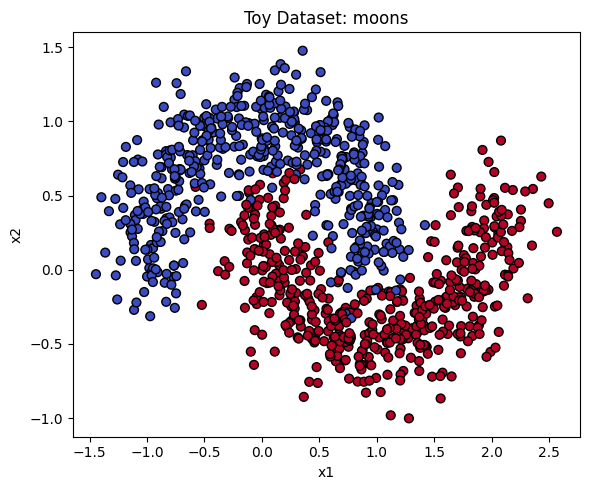

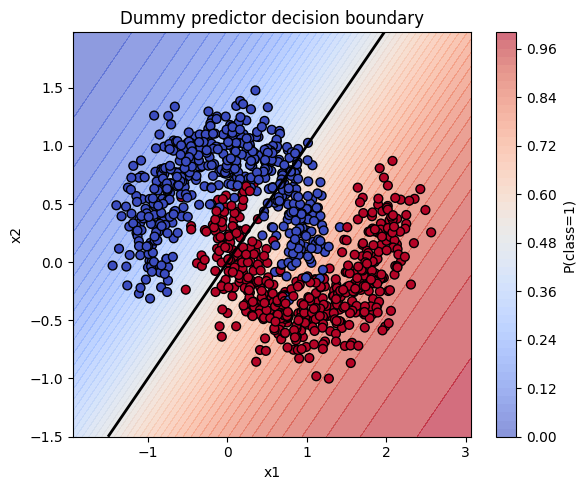

In [8]:
# ------------------------------------------------------------
# Generate a toy 2D dataset for binary classification
# ------------------------------------------------------------
# We use synthetic datasets from scikit-learn because they are:
#   - easy to generate,
#   - easy to visualize in 2D,
#   - non-linearly separable (for "moons"/"circles"), which makes them
#     a nice benchmark for a small neural network.
#
# Options:
#   - "moons"   : two interleaving half-moons (non-linear boundary)
#   - "circles" : concentric circles (non-linear boundary)
#   - "blobs"   : two Gaussian blobs (often close to linearly separable)

dataset_type = "moons"

X, y = generate_toy_dataset(
    n_samples=1000,          # total number of points
    noise=0.2,               # higher noise → harder classification
    dataset_type=dataset_type,
    random_state=42,         # reproducible dataset
)

# ------------------------------------------------------------
# Visualize the raw dataset
# ------------------------------------------------------------
# This plot shows the input distribution and the class labels (0/1).
visualize_dataset(X, y, title=f"Toy Dataset: {dataset_type}")

# ------------------------------------------------------------
# Sanity check: decision boundary of a dummy predictor
# ------------------------------------------------------------
# Before training our network, we plot the decision boundary of a simple
# hand-crafted predictor to verify that the boundary plotting helper works.
#
# Note: This dummy model is not expected to solve "moons" or "circles" well.
plot_decision_boundary(
    dummy_predict_fn,
    X,
    y,
    title="Dummy predictor decision boundary",
)


## Build the Neural Net

In [9]:
# ------------------------------------------------------------
# Arrange inputs and outputs in column-wise (batch) format
# ------------------------------------------------------------
# Throughout this notebook, we follow the convention:
#   - each column corresponds to ONE training example
#   - rows correspond to features (or neurons)
#
# This matches the matrix notation used in the blog post:
#   X ∈ R^{d_0 × N},  Y ∈ R^{d_L × N}

X_in = X.T                # shape: (d_0, N)
y_in = y.reshape(1, -1)   # shape: (1, N) for binary classification

# ------------------------------------------------------------
# Infer network input/output dimensions from the data
# ------------------------------------------------------------
dim_inputs = X_in.shape[0]    # d_0 (input dimension)
dim_outputs = y_in.shape[0]   # d_L (output dimension)

# ------------------------------------------------------------
# Define the neural network architecture
# ------------------------------------------------------------
# Architecture:
#   Input layer  : d_0 features
#   Hidden layer : 16 neurons (sigmoid activation)
#   Hidden layer : 32 neurons (sigmoid activation)
#   Output layer : 1 neuron (sigmoid activation for BCE loss)
#
# Note:
# - We deliberately keep the network small and simple.
# - Sigmoid activations are used everywhere to keep the math
#   consistent with the derivations in the blog post.
# - The learning rate is passed here for simplicity; in practice
#   it is often configured in the training loop instead.

net = NeuralNetwork(
    layers=[
        Input("input_layer", n_features=dim_inputs),
        Dense("hidden_layer_1", units=16),
        Dense("hidden_layer_2", units=32),
        Dense("output_layer", units=dim_outputs),
    ],
    loss_fn=bce_cost,
    lr=1.0,
)


## Train the Neural Net

In [10]:
# ------------------------------------------------------------
# Train the neural network
# ------------------------------------------------------------
# We now run the full training loop using backpropagation and
# gradient descent.
#
# Heuristic expectation:
#   - For this simple toy problem and network size, the final
#     cost should typically fall below ~0.10.
#   - If training stagnates above this value, it is often due to
#     unlucky random initialization (local minima or saddle points).
#     In that case, simply re-running the cell is usually sufficient.

costs = net.fit(
    X=X_in,                 # input batch (d_0 × N)
    y=y_in,                 # target labels (1 × N)
    epochs=2000,            # number of training iterations
    print_every=100,        # report cost every 100 epochs
    grad_check_every=199,   # occasionally run gradient checking
)

Epoch: 0  Cost J(Θ): 0.83744
Epoch: 100  Cost J(Θ): 0.30420
Epoch: 200  Cost J(Θ): 0.28970
Epoch: 300  Cost J(Θ): 0.28926
Epoch: 400  Cost J(Θ): 0.28883
Epoch: 500  Cost J(Θ): 0.28831
Epoch: 600  Cost J(Θ): 0.28744
Epoch: 700  Cost J(Θ): 0.28534
Epoch: 800  Cost J(Θ): 0.27756
Epoch: 900  Cost J(Θ): 0.24627
Epoch: 1000  Cost J(Θ): 0.18250
Epoch: 1100  Cost J(Θ): 0.13075
Epoch: 1200  Cost J(Θ): 0.10529
Epoch: 1300  Cost J(Θ): 0.09317
Epoch: 1400  Cost J(Θ): 0.08909
Epoch: 1500  Cost J(Θ): 0.08499
Epoch: 1600  Cost J(Θ): 0.08141
Epoch: 1700  Cost J(Θ): 0.07980
Epoch: 1800  Cost J(Θ): 0.07930
Epoch: 1900  Cost J(Θ): 0.08033


## Evaluate Classification Accuracy

In [11]:
# ------------------------------------------------------------
# Evaluate classification accuracy (quick sanity check)
# ------------------------------------------------------------
# Since the network uses a sigmoid output layer together with
# binary cross-entropy loss, the network output represents
# P(y = 1 | x).
#
# To obtain hard class labels, we apply a threshold at 0.5:
#   - y_pred >= 0.5  → class 1
#   - y_pred <  0.5  → class 0
#
# This simple accuracy metric is not meant as a full evaluation,
# but provides a quick sanity check that training was successful.

# Forward pass on the full dataset
y_pred = net.forward(X_in)          # shape: (1, N), values in [0, 1]

# Convert probabilities to binary predictions
y_pred_labels = (y_pred >= 0.5).astype(int)

# Compute accuracy
accuracy = np.mean(y_pred_labels == y_in)

print(f"Training accuracy: {accuracy:.3f}")

Training accuracy: 0.974


## Visualizing the Decision Boundary of the Net on the Training Data

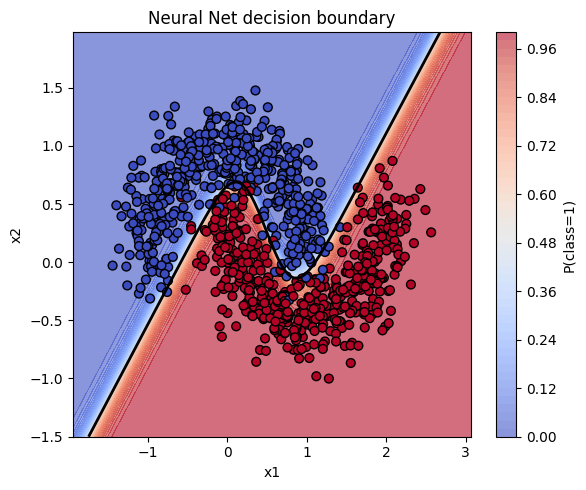

In [12]:
# ------------------------------------------------------------
# Visualize the learned decision boundary
# ------------------------------------------------------------
# To plot the decision boundary, we need a prediction function
# that maps points in R^2 to model outputs.
#
# Important:
# - plot_decision_boundary() expects input of shape (N, 2)
# - our network expects column-wise input of shape (2, N)
#   → hence the transpose inside the lambda

predict_fn = lambda xx: net.forward(xx.T)

# Plot the learned decision boundary together with the data
plot_decision_boundary(
    predict_fn,
    X,
    y,
    title="Neural Net decision boundary",
)